In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison

%load_ext autoreload
%autoreload 2

### mtcars

In [150]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["am"] = pd.Categorical(data["am"], categories=[0, 1], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

In [151]:
# Define and fit the Bambi model
mt_model = bmb.Model("mpg ~ hp * drat * am", data)
mt_idata = mt_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [5]:
az.summary(mt_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.199,13.415,-13.335,37.366,0.354,0.251,1435.0,1685.0,1.00
hp,-0.014,0.084,-0.179,0.141,0.002,0.002,1331.0,1775.0,1.01
drat,3.735,3.797,-3.023,11.266,0.101,0.073,1410.0,1726.0,1.00
hp:drat,-0.012,0.025,-0.057,0.037,0.001,0.000,1348.0,1806.0,1.00
am[1],2.029,14.087,-22.234,30.039,0.358,0.253,1550.0,2032.0,1.00
hp:am[1],0.055,0.089,-0.112,0.220,0.002,0.002,1469.0,2046.0,1.00
drat:am[1],0.357,3.614,-6.505,6.869,0.098,0.069,1357.0,1737.0,1.00
hp:drat:am[1],-0.013,0.025,-0.056,0.035,0.001,0.000,1378.0,2069.0,1.00
mpg_sigma,3.079,0.449,2.311,3.940,0.009,0.006,2715.0,2410.0,1.00


Like `plot_cap` the user must also pass the `model` and `idata`. However, for `plot_comparisons`, the user needs to pass a `contrast_predictor` and `conditional` argument. `contrast_predictor` is the variable whose contrast we are interested in computing comparisons (the difference between predictions) for. `conditional` is the variable that we are conditioning on.

Currently, the `plot_comparisons` function allows the user to pass either `str`, `list`, or `dict` into `contrast_predictor` and `conditional`. A `dict` is used to compare predictions of user defined contrasts. I think this data structure is a good representation since the key, value pair reads as "predictor" : "contrast". If a `str` or `list` is passed, the function will use a grid based on the observed data.

To compute the contrasts, the cartesion product (cross join) is used to compute all pairwise combinations of the `contrast_predictor` and `conditional` variables which is stored as a dataframe. This dataframe, like the `create_cap_data` dataframe, is used as the new data for the model to perform predictions. To compute the difference in predictions (comparison) of the contrasts, multiple pandas methods are chained:
1. `.groupby()` is used to group the dataframe by the covariates in the model (excluding the contrast predictor)
2. `.diff()` is used to compute the difference between the predictions of the contrasts
3. `.dropna()` is used to remove the first row of each group since the difference is computed between the current row and the previous row
4. `.reset_index()` is used to reset the index of the dataframe

The result of steps 1-4 are saved in a new dataframe—`contrast_comparison`. Conditional variable values are added to the dataframe and the dataframe is passed to `plot_comparison` to plot the comparisons.

contrast_predictor: {'hp': [110, 175]}
main: am, group: drat, panel: None
model covariates: ['am', 'drat']
HERE


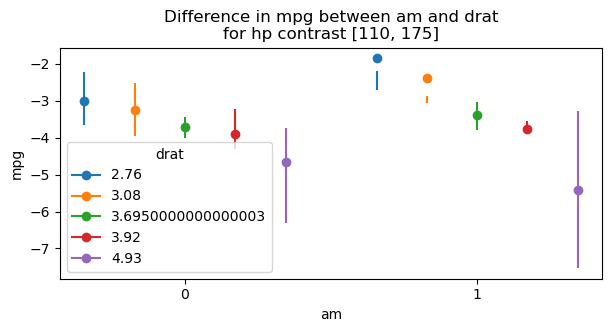

In [6]:
# user defined contrast for `hp`
# grid is determined for `am` and `drat`
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    mt_model,
    mt_idata,
    contrast_predictor={"hp": [110, 175]},
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

contrast_predictor: hp
model covariates: {'main': 'am', 'group': 'drat', 'panel': None}
[146.1875, 147.1875]


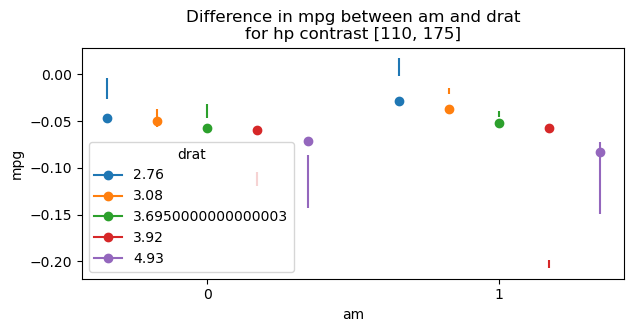

In [154]:
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    mt_model,
    mt_idata,
    contrast_predictor="hp",
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

### Palmer penguins

In [22]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)
data = data.dropna(axis=0, how="any")

In [83]:
data["species"] = pd.Categorical(data["species"])
data["island"] = pd.Categorical(data["island"])

In [84]:
penguin_model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
penguin_idata = penguin_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.


contrast_predictor: ['flipper_length_mm']
main: bill_length_mm, group: species, panel: None
model covariates: ['bill_length_mm', 'species', 'island']


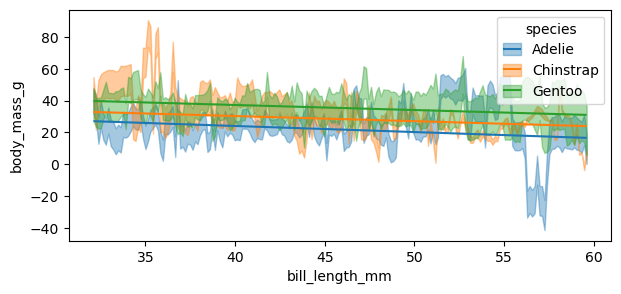

In [85]:
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast_predictor=["flipper_length_mm"],
    conditional=["bill_length_mm", "species"]
)
fig.set_size_inches(7, 3)

In [51]:
# HDI does not include the mean contrast comparison...
contrast_df

,estimate,hdi_3%,hdi_97%,bill_length_mm,species
0,27.068395,31.656234,47.725210,32.100000,Adelie
1,32.841295,36.742993,54.692950,32.100000,Chinstrap
2,39.724979,47.558343,27.397502,32.100000,Gentoo
3,27.015909,27.670022,43.843105,32.238191,Adelie
4,32.796798,21.727677,38.872678,32.238191,Chinstrap
...,...,...,...,...,...
595,24.030917,-3.644115,-0.958556,59.461809,Chinstrap
596,31.062888,44.355995,13.978242,59.461809,Gentoo
597,16.623552,0.342328,19.052322,59.600000,Adelie
598,23.986420,5.776226,8.969351,59.600000,Chinstrap


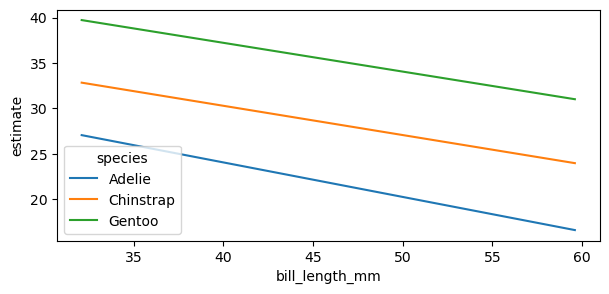

In [52]:
# should be???
plt.figure(figsize=(7, 3))
sns.lineplot(
    data=contrast_df,
    x="bill_length_mm",
    y="estimate",
    hue="species"
);

contrast_predictor: {'flipper_length_mm': [172, 231]}
model covariates: {'main': 'island', 'group': 'species', 'panel': None}


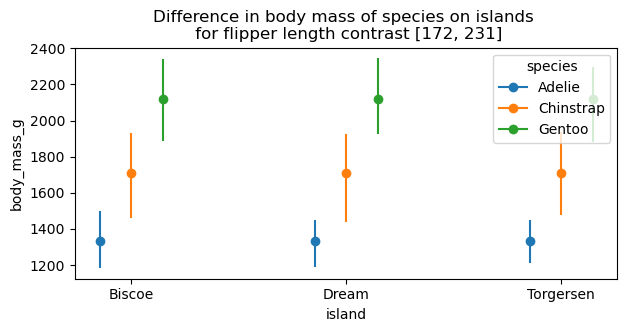

In [135]:
fig, ax, comparisons_df, contrast_df, idata  = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast_predictor={"flipper_length_mm": [172, 231]},
    conditional=["island", "species"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in body mass of species on islands \n for flipper length contrast [172, 231]");

### Titanic

In [2]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [3]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)

In [4]:
dat = dat.dropna(axis=0, how="any")

In [5]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="bernoulli"
)

titanic_idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Modeling the probability that Survived==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [134]:
az.summary(titanic_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.557,0.592,0.455,2.658,0.014,0.010,1898.0,2500.0,1.0
PClass[2.0],0.188,0.904,-1.491,1.885,0.022,0.016,1594.0,2342.0,1.0
PClass[3.0],-2.038,0.776,-3.495,-0.588,0.018,0.013,1795.0,2306.0,1.0
SexCode[1],1.090,1.238,-1.199,3.418,0.036,0.026,1201.0,1871.0,1.0
"PClass:SexCode[2.0, 1]",0.176,1.644,-2.901,3.206,0.047,0.033,1212.0,2053.0,1.0
"PClass:SexCode[3.0, 1]",-0.801,1.381,-3.434,1.792,0.040,0.028,1245.0,1785.0,1.0
Age,-0.056,0.015,-0.082,-0.027,0.000,0.000,1856.0,2411.0,1.0
PClass:Age[2.0],-0.090,0.033,-0.156,-0.030,0.001,0.001,1749.0,2195.0,1.0
PClass:Age[3.0],0.003,0.025,-0.044,0.049,0.001,0.000,1935.0,2673.0,1.0
SexCode:Age[1],0.069,0.032,0.010,0.128,0.001,0.001,1318.0,1865.0,1.0


contrast_predictor: {'Age': [50, 70]}
model covariates: {'main': 'SexCode', 'group': None, 'panel': None}
contrast term: Age
contrast value: [50, 70]


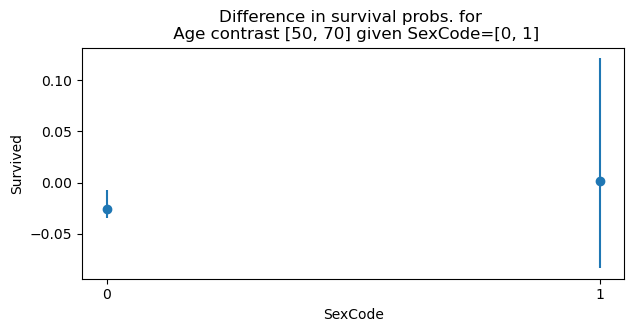

In [200]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"Age": [50, 70]},
    conditional="SexCode",
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast [50, 70] given SexCode=[0, 1]");

contrast_predictor: Age
model covariates: {'main': 'SexCode', 'group': None, 'panel': None}
contrast term: Age
contrast value: [29.89798942 30.89798942]


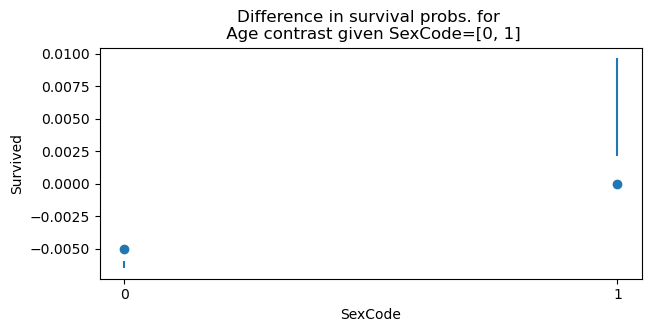

In [236]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor="Age",
    conditional="SexCode",
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast given SexCode=[0, 1]");

In [237]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,SexCode
0,-0.005023,-0.006518,-0.005954,Age,"[29.9, 30.9]",0
1,-0.000058,0.002160,0.009651,Age,"[29.9, 30.9]",1


contrast_predictor: {'PClass': [1, 3]}
model covariates: {'main': 'Age', 'group': 'SexCode', 'panel': None}
contrast term: PClass
contrast value: [1. 3.]


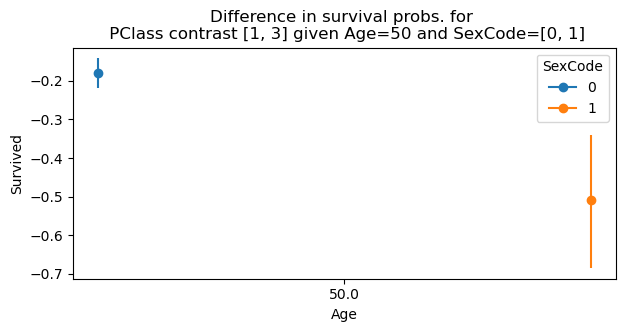

In [234]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"PClass": [1, 3]},
    conditional={"Age": [50], "SexCode": [0, 1]}
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age=50 and SexCode=[0, 1]");

In [238]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"PClass": [1, 3]},
    conditional=["Age", "SexCode"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age=50 and SexCode=[0, 1]");

contrast_predictor: {'PClass': [1, 3]}
model covariates: {'main': 'Age', 'group': 'SexCode', 'panel': None}
contrast term: PClass
contrast value: [1. 3.]


ValueError: cannot reshape array of size 800 into shape (400,400)